In [28]:
################################################################################
## EXAMPLE FROM https://www.tensorflow.org/tutorials/images/transfer_learning ##
################################################################################


import matplotlib.pyplot as plt
import numpy as np
import os as os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# To prevent get all GPU memory
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


## PETAAAAA només començar, al llegir les imatges
##gpus = tf.config.experimental.list_physical_devices('GPU')
##tf.config.experimental.set_memory_growth(gpus[0], True)
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
####tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  2


In [29]:
'''
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
'''
# cats - dogs
#train_dir = os.path.join('/home/jovyan/work/model/transfer_learning/tf_examples/exemple_1/cats_and_dogs_filtered_small/', 'train')
#validation_dir = os.path.join('/home/jovyan/work/model/transfer_learning/tf_examples/exemple_1/cats_and_dogs_filtered_small/', 'validation')

# tumor - normal
PATH = '/home/jovyan/work/model/transfer_learning/tf_examples/exemple_1/data_test_meu/' # amb JPG PETA!!
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')


BATCH_SIZE = 32 # 32 = original --> Peta memoria
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


Found 107 files belonging to 2 classes.


In [30]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 5 files belonging to 2 classes.


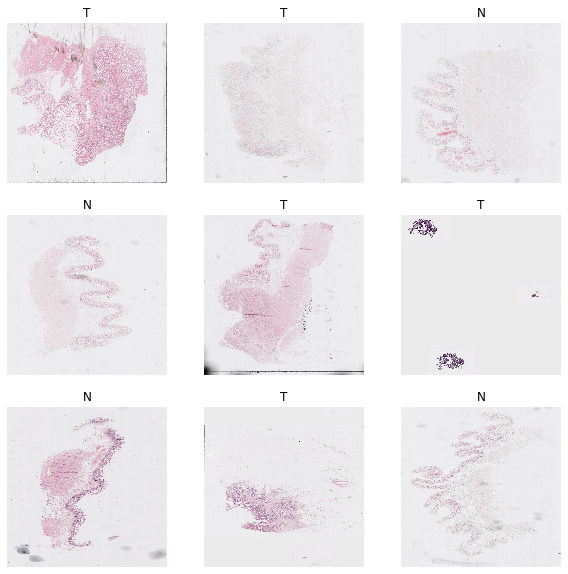

In [31]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [32]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 1
Number of test batches: 0


In [33]:
### Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE

####################################################################################################################################
## mon
# Para tener GPU cargamos el entorno de ejecución (Entorno de Ejecucion -> Cambiar tipo de entorno de ejecucion -> GPU)
try:
    strategy = tf.distribute.MirroredStrategy()
    print("\nNumber of GPUs: ", strategy.num_replicas_in_sync, "\n")
except ValueError:
    print("\nThere is no GPU available. Change the environment to continue\n")
    


    
####################################################################################################################################

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')

Number of GPUs:  2 



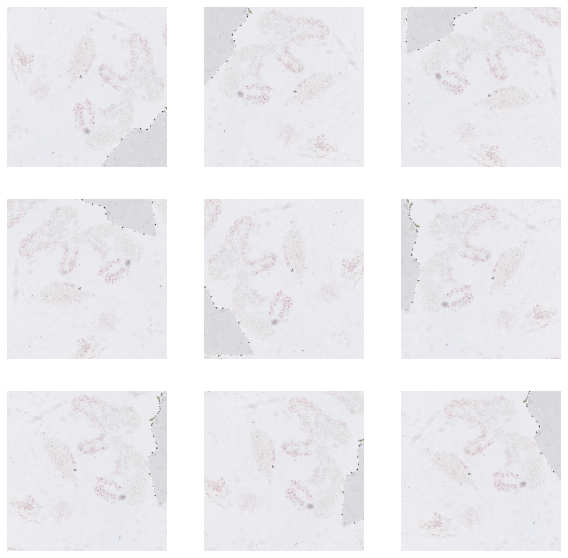

In [34]:
### Use data augmentation

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Let's repeatedly apply these layers to the same image and see the result.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [35]:
## Normalization pixel values (-1, 1) - Rescale pixel values

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Note: Alternatively, you could rescale pixel values from [0,255] to [-1, 1] using a Rescaling layer.
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


In [36]:
### Create the base model from the pre-trained convnets

# First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet.
# By specifying the include_top=False argument, you load a network that doesn't include 
# the classification layers at the top, which is ideal for feature extraction.

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [37]:
#This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
# Let's see what it does to an example batch of images:

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [38]:
#Freeze the convolutional base

# It is important to freeze the convolutional base before you compile and train the model.
# Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training.
# MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

base_model.trainable = False

# Let's take a look at the base model architecture
# base_model.summary()


In [39]:
#Add a classification head

# To generate predictions from the block of features, average over the spatial 5x5 spatial locations, 
# using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image.
# You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. 
# Positive numbers predict class 1, negative numbers predict class 0.

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1280)
(32, 1)


In [40]:
# Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.
# As previously mentioned, use training=False as our model contains a BatchNormalization layer.

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [41]:
#Compile the model

# Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with from_logits=True 
# since the model provides a linear output.

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

print("\nlength model = ", len(model.trainable_variables))




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [42]:
#Train the model

# After training for 10 epochs, you should see ~94% accuracy on the validation set.

loss0, accuracy0 = model.evaluate(validation_dataset)

print("\n\nLoss / accuracy from transfer-learning trained model")
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("\n")


initial_epochs = 10
print("Add ", initial_epochs, " epochs training\n")
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


1/1 [==============================] - 59s 59s/step - loss: 0.5033 - accuracy: 1.0000


Loss / accuracy from transfer-learning trained model
initial loss: 0.50
initial accuracy: 1.00


Add  10  epochs training

Epoch 1/10
4/4 [==============================] - 101s 20s/step - loss: 0.7611 - accuracy: 0.4019 - val_loss: 0.5105 - val_accuracy: 0.8000
Epoch 2/10
4/4 [==============================] - 39s 359ms/step - loss: 0.7254 - accuracy: 0.5421 - val_loss: 0.5205 - val_accuracy: 0.8000
Epoch 3/10
4/4 [==============================] - 42s 415ms/step - loss: 0.7103 - accuracy: 0.5047 - val_loss: 0.5324 - val_accuracy: 0.8000
Epoch 4/10
4/4 [==============================] - 44s 387ms/step - loss: 0.7308 - accuracy: 0.4860 - val_loss: 0.5435 - val_accuracy: 0.8000
Epoch 5/10
4/4 [==============================] - 39s 339ms/step - loss: 0.7060 - accuracy: 0.5327 - val_loss: 0.5555 - val_accuracy: 0.8000
Epoch 6/10
4/4 [==============================] - 41s 387ms/step - loss: 0.7037 - acc

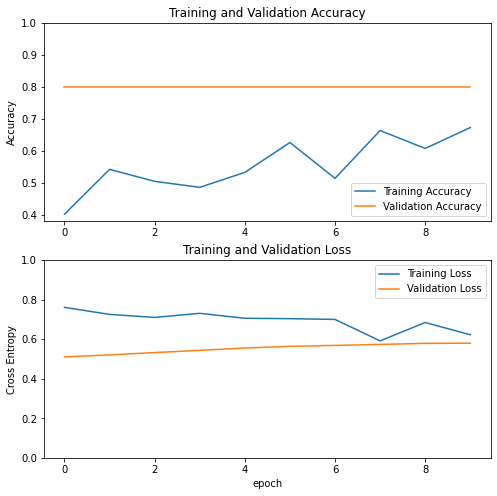

In [43]:
# learning curves of the training and validation accuracy/loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
